In [44]:
import requests
import lxml
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt



In [4]:
def new_data(cursor, school_id):
    data = {
        "query":"query TeacherSearchPaginationQuery(\n  $count: Int!\n  $cursor: String\n  $query: TeacherSearchQuery!\n) {\n  search: newSearch {\n    ...TeacherSearchPagination_search_1jWD3d\n  }\n}\n\nfragment TeacherSearchPagination_search_1jWD3d on newSearch {\n  teachers(query: $query, first: $count, after: $cursor) {\n    didFallback\n    edges {\n      cursor\n      node {\n        ...TeacherCard_teacher\n        id\n        __typename\n      }\n    }\n    pageInfo {\n      hasNextPage\n      endCursor\n    }\n    resultCount\n    filters {\n      field\n      options {\n        value\n        id\n      }\n    }\n  }\n}\n\nfragment TeacherCard_teacher on Teacher {\n  id\n  legacyId\n  avgRating\n  numRatings\n  ...CardFeedback_teacher\n  ...CardSchool_teacher\n  ...CardName_teacher\n  ...TeacherBookmark_teacher\n}\n\nfragment CardFeedback_teacher on Teacher {\n  wouldTakeAgainPercent\n  avgDifficulty\n}\n\nfragment CardSchool_teacher on Teacher {\n  department\n  school {\n    name\n    id\n  }\n}\n\nfragment CardName_teacher on Teacher {\n  firstName\n  lastName\n}\n\nfragment TeacherBookmark_teacher on Teacher {\n  id\n  isSaved\n}\n",
        "variables":{
            "count": 8,
            "cursor": cursor, 
            "query":{
                "text":"",
                "schoolID":school_id,
                "fallback":True,
                #"departmentID":"RGVwYXJ0bWVudC0xNDA=", 
            }
        }
    } 
    return data

In [5]:
def fetch_info(dic): 
    name = dic['node']['firstName'] + " " + dic['node']['lastName']
    lid = "/professor?tid=" + str(dic['node']['legacyId'])
    department = dic['node']['department']
    rating = dic['node']['avgRating']
    return name, department, rating
    
#prof_list = result['data']['search']['teachers']['edges']
    
#[fetch_info(prof) for prof in prof_list]

In [12]:


def fetch_profs(school_id): 
    endpoint = 'https://www.ratemyprofessors.com/graphql'
    headers = {
        "Authorization": "Basic dGVzdDp0ZXN0", 
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:136.0) Gecko/20100101 Firefox/136.0"
        #"Cookie": "AWSALB=AbwlpXoOgh8jzRRTyJeNIbsjQXFxt1kFTfGPDsY4oP1NrRRc6XpFWBxYTUpFryN+9eCYMAl5om17jlmcAnjGRnqHtzxcTJOME+uQJYSgirzgvQR7p1XkTO74DUkVMBdb5EDbNHYGUcVBcR1T3J3GOlDB3a4eTxbAE64V1RFw0BMLafSS0wLSggCVXg6z8w==; AWSALBCORS=AbwlpXoOgh8jzRRTyJeNIbsjQXFxt1kFTfGPDsY4oP1NrRRc6XpFWBxYTUpFryN+9eCYMAl5om17jlmcAnjGRnqHtzxcTJOME+uQJYSgirzgvQR7p1XkTO74DUkVMBdb5EDbNHYGUcVBcR1T3J3GOlDB3a4eTxbAE64V1RFw0BMLafSS0wLSggCVXg6z8w==; ccpa-notice-viewed-02=true; previousSchoolID=1073; ad_blocker_overlay_2019=false; cid=PXNma9PY7p-20230408; RMP_AUTH_COOKIE_VERSION=v01"
    }
    
    # first query
    data = {
        "query":"query TeacherSearchResultsPageQuery(\n  $query: TeacherSearchQuery!\n  $schoolID: ID\n) {\n  search: newSearch {\n    ...TeacherSearchPagination_search_1ZLmLD\n  }\n  school: node(id: $schoolID) {\n    __typename\n    ... on School {\n      name\n    }\n    id\n  }\n}\n\nfragment TeacherSearchPagination_search_1ZLmLD on newSearch {\n  teachers(query: $query, first: 8, after: \"\") {\n    didFallback\n    edges {\n      cursor\n      node {\n        ...TeacherCard_teacher\n        id\n        __typename\n      }\n    }\n    pageInfo {\n      hasNextPage\n      endCursor\n    }\n    resultCount\n    filters {\n      field\n      options {\n        value\n        id\n      }\n    }\n  }\n}\n\nfragment TeacherCard_teacher on Teacher {\n  id\n  legacyId\n  avgRating\n  numRatings\n  ...CardFeedback_teacher\n  ...CardSchool_teacher\n  ...CardName_teacher\n  ...TeacherBookmark_teacher\n}\n\nfragment CardFeedback_teacher on Teacher {\n  wouldTakeAgainPercent\n  avgDifficulty\n}\n\nfragment CardSchool_teacher on Teacher {\n  department\n  school {\n    name\n    id\n  }\n}\n\nfragment CardName_teacher on Teacher {\n  firstName\n  lastName\n}\n\nfragment TeacherBookmark_teacher on Teacher {\n  id\n  isSaved\n}\n",
        "variables":{
            "query":{
                "text":"",
                "schoolID":school_id,
                "fallback":True,
                #"departmentID":"RGVwYXJ0bWVudC0xNDA=", 
            },
            "schoolID": school_id
        }
    } 
    
    response = requests.post(endpoint, headers = headers, json=data)
    result = response.json()
    
    prof_list = result['data']['search']['teachers']['edges']
    df = [fetch_info(prof) for prof in prof_list]
    
    cursor = result['data']['search']['teachers']['pageInfo']['endCursor']
    
    flag = True
    while flag: 
        data = new_data(cursor, school_id)
        
        # Create a session
        session = requests.Session()
        session.headers.update(headers)
        response = session.post(endpoint, headers=headers, json=data)
        result = response.json()
            
        prof_list = result['data']['search']['teachers']['edges']
        df.extend([fetch_info(prof) for prof in prof_list])
        cursor = result['data']['search']['teachers']['pageInfo']['endCursor']

        flag = result['data']['search']['teachers']['pageInfo']['hasNextPage']
        
    return df



In [13]:


df = fetch_profs("U2Nob29sLTEwNzM=")



In [14]:
df[:5]

[('Bryan Enderle', 'Chemistry', 4.6),
 ('Korana Burke', 'Mathematics', 2.9),
 ('Marc Facciotti', 'Biomedical Engineering', 3),
 ('Andrew Farris', 'Statistics', 2.4),
 ('Diego Yankelevich', 'Engineering', 2.2)]

In [15]:
df1 = pd.DataFrame(df, columns=['Name', 'Department', 'Rating'])
df1.head()

,Name,Department,Rating
0,Bryan Enderle,Chemistry,4.6
1,Korana Burke,Mathematics,2.9
2,Marc Facciotti,Biomedical Engineering,3.0
3,Andrew Farris,Statistics,2.4
4,Diego Yankelevich,Engineering,2.2


In [16]:
avg_rating = sum(df1['Rating']) / len(df1['Rating'])
avg_rating

3.744439481911539

In [17]:
def get_data(cursor):
    data = {
        "query":"query SchoolRatingsListQuery(  $count: Int!  $id: ID!  $cursor: String) {  node(id: $id) {    __typename    ... on School {      ...SchoolRatingsList_school_1G22uz    }    id  }}fragment SchoolRatingFooter_rating on SchoolRating {  id  comment  flagStatus  legacyId  ...Thumbs_schoolRating}fragment SchoolRatingFooter_school on School {  id  legacyId  ...Thumbs_school}fragment SchoolRatingSuperHeader_school on School {  name  legacyId}fragment SchoolRating_rating on SchoolRating {  clubsRating  comment  date  facilitiesRating  foodRating  happinessRating  internetRating  locationRating  opportunitiesRating  reputationRating  safetyRating  socialRating  legacyId  flagStatus  createdByUser  ...SchoolRatingFooter_rating}fragment SchoolRating_school on School {  ...SchoolRatingSuperHeader_school  ...SchoolRatingFooter_school}fragment SchoolRatingsList_school_1G22uz on School {  id  name  city  state  country  legacyId  ratings(first: $count, after: $cursor) {    edges {      cursor      node {        ...SchoolRating_rating        id        __typename      }    }    pageInfo {      hasNextPage      endCursor    }  }  ...SchoolRating_school}fragment Thumbs_school on School {  id  legacyId}fragment Thumbs_schoolRating on SchoolRating {  id  legacyId  thumbsDownTotal  thumbsUpTotal  userThumbs {    computerId    thumbsUp    thumbsDown    id  }}",
        "variables":{
            "id":"U2Nob29sLTMwMjM=",
            "count": 10,
            "cursor": cursor
        }
    } 
    return data

In [18]:
def get_review(dic): 
    review = dic['node']['comment']
    return review

In [19]:
def fetch_univ(college_id): 
    endpoint = 'https://www.ratemyprofessors.com/graphql'
    headers = {
        "Authorization": "Basic dGVzdDp0ZXN0", 
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:136.0) Gecko/20100101 Firefox/136.0"
    }
        
    # first query
    data = {
        "query":"query SchoolRatingsListQuery(  $count: Int!  $id: ID!  $cursor: String) {  node(id: $id) {    __typename    ... on School {      ...SchoolRatingsList_school_1G22uz    }    id  }}fragment SchoolRatingFooter_rating on SchoolRating {  id  comment  flagStatus  legacyId  ...Thumbs_schoolRating}fragment SchoolRatingFooter_school on School {  id  legacyId  ...Thumbs_school}fragment SchoolRatingSuperHeader_school on School {  name  legacyId}fragment SchoolRating_rating on SchoolRating {  clubsRating  comment  date  facilitiesRating  foodRating  happinessRating  internetRating  locationRating  opportunitiesRating  reputationRating  safetyRating  socialRating  legacyId  flagStatus  createdByUser  ...SchoolRatingFooter_rating}fragment SchoolRating_school on School {  ...SchoolRatingSuperHeader_school  ...SchoolRatingFooter_school}fragment SchoolRatingsList_school_1G22uz on School {  id  name  city  state  country  legacyId  ratings(first: $count, after: $cursor) {    edges {      cursor      node {        ...SchoolRating_rating        id        __typename      }    }    pageInfo {      hasNextPage      endCursor    }  }  ...SchoolRating_school}fragment Thumbs_school on School {  id  legacyId}fragment Thumbs_schoolRating on SchoolRating {  id  legacyId  thumbsDownTotal  thumbsUpTotal  userThumbs {    computerId    thumbsUp    thumbsDown    id  }}",
        "variables":{
            "id":college_id,
            "count": 10,
            "cursor": "YXJyYXljb25uZWN0aW9uOjI5"
        }
    } 
    
    response = requests.post(endpoint, headers = headers, json=data)
    result = response.json()
    
    review_list = result['data']['node']['ratings']['edges']
    df = [get_review(review) for review in review_list]
    
    cursor = result['data']['node']['ratings']['pageInfo']['endCursor']
    
    flag = True
    while flag: 
        data = get_data(cursor)
        
        # Create a session
        session = requests.Session()
        session.headers.update(headers)

        response = session.post(endpoint, headers=headers, json=data)
        
        result = response.json()
            
        review_list = result['data']['node']['ratings']['edges']
        df.extend([get_review(review) for review in review_list])
        cursor = result['data']['node']['ratings']['pageInfo']['endCursor']

        flag = result['data']['node']['ratings']['pageInfo']['hasNextPage']
        
    return df

In [20]:
df = fetch_univ('U2Nob29sLTE5NTM=')

In [21]:
new_df = [x for x in df if x != 'None.' and x != 'Not Specified.']

In [22]:
df_reviews = pd.DataFrame(new_df, columns=['Review'])
df_reviews.head()

,Review
0,"Very quiet, calm campus. Gorgeous plant-life. ..."
1,only because i have to ...
2,You need to be on their case 247 they don&#39;...
3,Great Campus that went through a pretty big ov...
4,"Peaceful, clean campus without a lot of people..."


In [23]:


from textblob import TextBlob
     

# Performs sentiment analysis for each university
review_polarity = []

for i in range(len(df_reviews['Review'])):
  opinion = TextBlob(df_reviews['Review'][i])
  review_polarity.append(opinion.sentiment[0])


     

df_reviews['Polarity'] = review_polarity # Polarity is how positive the sentiment is from 0 to 1

In [24]:
df_reviews.head()

,Review,Polarity
0,"Very quiet, calm campus. Gorgeous plant-life. ...",0.145655
1,only because i have to ...,0.000000
2,You need to be on their case 247 they don&#39;...,0.600000
3,Great Campus that went through a pretty big ov...,0.262824
4,"Peaceful, clean campus without a lot of people...",0.195833


In [25]:
avg_sentiment = sum(df_reviews['Polarity']) / len(df_reviews['Polarity'])
avg_sentiment

0.35739338380461255

In [26]:
import scripts.cccco as cccco
import scripts.college_scorecard as scorecard
import scripts.labor_market as labor_market
import scripts.join_tools as join_tools

In [27]:
all_colleges = cccco.get_ccc_colleges()

In [28]:
print(f"{all_colleges.shape[0]:,} rows")
all_colleges.head()

115 rows


,CollegeID,CollegeName,DistrictID,StreetAddress,City,County,Zip,ZipPlus4,MailingAddress,MailingCity,MailingZip,Phone,WebsiteURL,Latitude,Longitude,LogoURL,District
0,021,Cuyamaca College,020,900 Rancho San Diego Parkway,El Cajon,San Diego,92019,4304,900 Rancho San Diego Parkway,El Cajon,92019,619.660.4000,www.cuyamaca.edu,32.744890,-116.935229,CuyamacaCollegeLogo.jpg,None
1,022,Grossmont College,020,8800 Grossmont College Drive,El Cajon,San Diego,92020,1799,8800 Grossmont College Drive,El Cajon,92020,619.644.7000,www.grossmont.edu,32.817897,-117.005640,GrossmontCollegelogo.jpg,None
2,031,Imperial Valley College,030,380 East Aten Road,Imperial,Imperial,92251,9787,380 East Aten Road,Imperial,92251,760.352.8320,www.imperial.edu,32.825859,-115.502999,ImperialValleyCollegeLogocopy.jpg,None
3,051,MiraCosta College,050,1 Barnard Drive,Oceanside,San Diego,92056,3899,1 Barnard Drive,Oceanside,92056,760.757.2121,www.miracosta.edu,33.188864,-117.301064,Mira_Costa_College_Logo_4c.png,None
4,061,Palomar College,060,1140 West Mission Road,San Marcos,San Diego,92069,1487,1140 West Mission Road,San Marcos,92069,760.744.1150,www.palomar.edu,33.147015,-117.183980,PalomarCollegeLogo.jpg,None


In [29]:
def get_id(college):
    url = 'https://www.ratemyprofessors.com/graphql'
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:136.0) Gecko/20100101 Firefox/136.0',
        'Authorization': 'Basic dGVzdDp0ZXN0',
        'Content-Type': 'application/json'
    }
    
    query = """
    query NewSearchSchoolsQuery(
      $query: SchoolSearchQuery  
      $includeCompare: Boolean!
    ) {
      newSearch {
        schools(query: $query) {
          edges {
            node {
              id
              name
              city
              state          
              name @include(if: $includeCompare)                  
            }
          }
        }
      }
    }
    """
    variables = {
        "query": {
            "text": college
        },
        "includeCompare": False
    }
    
    data = {
        'query': query,
        'variables': variables
        #'variables': '{"query":{"text":"De"},"includeCompare":false}'
    }
    
    # Create a session
    session = requests.Session()
    session.headers.update(headers)
    
    response = session.post(url, headers=headers, json=data)
    
    #print(response)
    #print(json.dumps(response.json(), indent=4))
    
    resp_js = response.json()
    
    name = response.json()['data']['newSearch']['schools']['edges'][0]['node']['name']
    college_id = response.json()['data']['newSearch']['schools']['edges'][0]['node']['id']
    #print(f'name={name}, id={id}')
    return college_id



In [30]:
college_list = all_colleges['CollegeName']
college_list[:5]

0           Cuyamaca College
1          Grossmont College
2    Imperial Valley College
3          MiraCosta College
4            Palomar College
Name: CollegeName, dtype: object

In [31]:
get_id('Cuyamaca College')

'U2Nob29sLTE5NTM='

In [32]:
id_list = []
for college in college_list:
    college_id = get_id(college)
    id_list.append(college_id)

In [33]:
len(id_list)

115

In [34]:
def get_sentiment(college_id):
    df = fetch_univ(college_id)
    new_df = [x for x in df if x != 'None.' and x != 'Not Specified.' and x != None]

    df_reviews = pd.DataFrame(new_df, columns=['Review'])

    # Performs sentiment analysis for each university
    review_polarity = []
    
    for i in range(len(df_reviews['Review'])):
      opinion = TextBlob(df_reviews['Review'][i])
      review_polarity.append(opinion.sentiment[0])
    
    df_reviews['Polarity'] = review_polarity # Polarity is how positive the sentiment is from 0 to 1

    avg_sentiment = sum(df_reviews['Polarity']) / len(df_reviews['Polarity'])
    return avg_sentiment

In [35]:
get_sentiment('U2Nob29sLTE5NTM=')

0.35739338380461255

In [36]:
sentiments = []
for college_id in id_list:
    sentiment = get_sentiment(college_id)
    sentiments.append(sentiment) 

In [37]:
sentiments[:10]

[0.35739338380461255,
 0.35832603682449815,
 0.3566306631622127,
 0.37619490937351774,
 0.3706711926898746,
 0.36807474944085783,
 0.37755109258754405,
 0.3801100973309851,
 0.36868917101387044,
 0.36642735462434534]

In [38]:
def get_rating(college_id):
    df = fetch_profs(college_id)
    df1 = pd.DataFrame(df, columns=['Name', 'Department', 'Rating'])
    avg_rating = sum(df1['Rating']) / len(df1['Rating'])
    return avg_rating
    

In [39]:
get_rating("U2Nob29sLTE1ODA=")

3.9940119760479034

In [40]:
ratings = []
for college_id in id_list:
    rating = get_rating(college_id)
    ratings.append(rating) 

In [41]:
ratings[:10]

[3.851304347826091,
 3.816608996539799,
 4.081674208144794,
 3.915432098765438,
 3.8887384948565296,
 3.96256983240224,
 3.8217654986522915,
 3.770818070818072,
 3.4189655172413795,
 3.8318857142857237]

In [42]:
data = {'College': college_list, 'Sentiment': sentiments, 'Rating': ratings}
final_data = pd.DataFrame(data)

In [43]:
final_data.head()

,College,Sentiment,Rating
0,Cuyamaca College,0.357393,3.851304
1,Grossmont College,0.358326,3.816609
2,Imperial Valley College,0.356631,4.081674
3,MiraCosta College,0.376195,3.915432
4,Palomar College,0.370671,3.888738


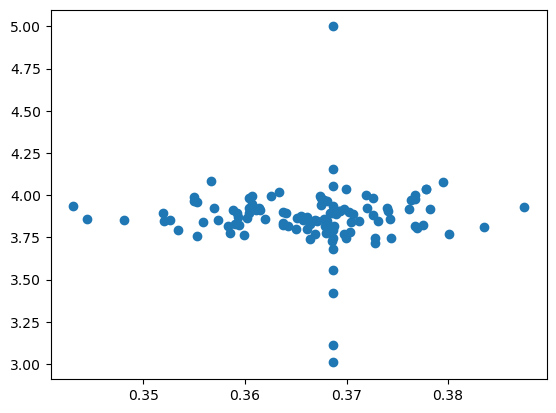

In [46]:
plt.scatter(final_data['Sentiment'], final_data['Rating'])

In [48]:
final_data.to_csv('project_data.csv')